In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        pass
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install --no-deps --no-index --find-links=/kaggle/input/egnn-required-libraries torch-scatter torch-geometric egnn-pytorch


Looking in links: /kaggle/input/egnn-required-libraries
Processing /kaggle/input/egnn-required-libraries/torch_scatter-2.1.2+pt26cu124-cp311-cp311-linux_x86_64.whl
Processing /kaggle/input/egnn-required-libraries/torch_geometric-2.6.1-py3-none-any.whl
Processing /kaggle/input/egnn-required-libraries/egnn_pytorch-0.2.8-py3-none-any.whl


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch_geometric
from torch_geometric.data import Data, DataLoader
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv, MessagePassing
from torch_geometric.utils import remove_self_loops, add_self_loops
import torch_scatter
from egnn_pytorch import EGNN  
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm
import random


# Set random seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.backends.cudnn.deterministic = True

set_seed(42)

In [4]:
MAX_SEQ_LEN = 1024

In [5]:
# Define paths to data files
TRAIN_SEQUENCES_PATH = "/kaggle/input/stanford-rna-3d-folding/train_sequences.csv"
TRAIN_LABELS_PATH = "/kaggle/input/stanford-rna-3d-folding/train_labels.csv"
# Load data
train_sequences = pd.read_csv(TRAIN_SEQUENCES_PATH)
train_labels = pd.read_csv(TRAIN_LABELS_PATH)

print(f"Loaded {len(train_sequences)} RNA sequences and {len(train_labels)} nucleotide labels")

Loaded 844 RNA sequences and 137095 nucleotide labels


In [6]:
# Preprocess data
# 1. Encoding nucleotides
nucleotide_mapping = {'A': 0, 'C': 1, 'G': 2, 'U': 3}
reverse_mapping = {0: 'A', 1: 'C', 2: 'G', 3: 'U'}

In [7]:
# 2. Create feature representation for each nucleotide
def one_hot_encode(nucleotide):
    encoding = [0, 0, 0, 0]
    if nucleotide in nucleotide_mapping:
        encoding[nucleotide_mapping[nucleotide]] = 1
    return encoding

In [8]:
# Function to create a graph from an RNA sequence
def sequence_to_graph(sequence, target_id, labels_df=None, max_connections=MAX_SEQ_LEN):
    """
    Create a graph representation of an RNA sequence.
    
    Args:
        sequence: The RNA sequence
        target_id: Identifier for the RNA
        labels_df: Optional dataframe with 3D coordinate labels
        max_connections: Maximum number of edges to create (to avoid CUDA OOM errors)
        
    Returns:
        PyTorch Geometric Data object
    """
    # One-hot encode each nucleotide
    x = [one_hot_encode(nt) for nt in sequence]
    x = torch.tensor(x, dtype=torch.float)
    
    # Create edges - connect adjacent nucleotides (backbone)
    # and potentially other connections based on domain knowledge
    edges = []
    
    # Always add backbone connections
    for i in range(len(sequence) - 1):
        # Connect to next nucleotide (backbone)
        edges.append([i, i + 1])
        edges.append([i + 1, i])  # Bidirectional
    
    # Add potential base-pairing connections, but limit total edges to avoid OOM
    edge_count = len(edges)
    max_additional_edges = max_connections - edge_count
    
    if max_additional_edges > 0:
        potential_base_pairs = []
        
        # Identify potential base pairs (A-U, G-C)
        for i in range(len(sequence)):
            for j in range(i + 3, len(sequence)):  # Minimum loop size of 3
                if (sequence[i] == 'A' and sequence[j] == 'U') or \
                   (sequence[i] == 'U' and sequence[j] == 'A') or \
                   (sequence[i] == 'G' and sequence[j] == 'C') or \
                   (sequence[i] == 'C' and sequence[j] == 'G'):
                    # Store the potential base pair
                    potential_base_pairs.append((i, j))
        
        # Randomly select base pairs if we have too many
        if len(potential_base_pairs) > max_additional_edges // 2:  # Divide by 2 for bidirectional edges
            # Shuffle and take only what we can handle
            random.shuffle(potential_base_pairs)
            potential_base_pairs = potential_base_pairs[:max_additional_edges // 2]
        
        # Add the selected base pairs
        for i, j in potential_base_pairs:
            edges.append([i, j])
            edges.append([j, i])  # Bidirectional
    
    # Convert edges to tensor
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    
    # Get coordinates if available
    y = None
    mask = None
    if labels_df is not None:
        target_labels = labels_df[labels_df['ID'].str.startswith(target_id + '_')]
        
        # Sort by residue ID to match sequence order
        target_labels = target_labels.sort_values(by='resid')
        
        # Check if we have the expected number of residues
        if len(target_labels) == len(sequence):
            # Extract coordinates for each residue
            coordinates = target_labels[['x_1', 'y_1', 'z_1']].values
            
            # Create a mask for NaN values (1 for valid, 0 for NaN)
            valid_mask = ~np.isnan(coordinates).any(axis=1)
            mask = torch.tensor(valid_mask, dtype=torch.float)
            
            # Replace NaN with zeros (we'll mask these during loss calculation)
            coordinates = np.nan_to_num(coordinates, nan=0.0)
            
            y = torch.tensor(coordinates, dtype=torch.float)
        else:
            print(f"Warning: Mismatch in sequence length and label count for {target_id}")
    
    # Create the data object with properly typed target_id (as string)
    data = Data(x=x, edge_index=edge_index, y=y, mask=mask)
    
    # Store target_id as a string attribute
    data.target_id = str(target_id)
    
    return data

In [9]:
def create_dataset(sequences_df, labels_df=None):
    dataset = []
    skipped_count = 0
    nan_count = 0
    
    for idx, row in tqdm(sequences_df.iterrows(), total=len(sequences_df)):
        target_id = row['target_id']
        sequence = row['sequence']
        
        # Clean sequence - replace any non-standard nucleotides with 'N'
        # and count how many non-standard nucleotides there are
        cleaned_sequence = ''
        non_standard_count = 0
        
        for nt in sequence:
            if nt in nucleotide_mapping:
                cleaned_sequence += nt
            else:
                cleaned_sequence += 'N'  # Placeholder for non-standard nucleotides
                non_standard_count += 1
        
        # If too many non-standard nucleotides (>10%), skip this sequence
        if non_standard_count / len(sequence) > 0.1:
            print(f"Skipping sequence {target_id} with {non_standard_count} non-standard nucleotides")
            skipped_count += 1
            continue
        
        # Create graph
        graph = sequence_to_graph(cleaned_sequence, target_id, labels_df)
        
        # Check if we have labels with many NaN values
        if labels_df is not None and hasattr(graph, 'mask') and graph.mask is not None:
            nan_percentage = 1.0 - torch.mean(graph.mask).item()
            if nan_percentage > 0.5:  # If more than 50% coordinates are NaN
                print(f"Warning: Sequence {target_id} has {nan_percentage:.1%} NaN coordinates")
                nan_count += 1
        
        # Add to dataset if no labels needed or valid labels exist
        if labels_df is None or graph.y is not None:
            dataset.append(graph)
    
    print(f"Dataset creation: {skipped_count} sequences skipped due to non-standard nucleotides")
    print(f"Dataset creation: {nan_count} sequences have >50% NaN coordinates")
    
    return dataset

In [10]:
data={
      "sequence":train_sequences['sequence'].to_list(),
      "temporal_cutoff": train_sequences['temporal_cutoff'].to_list(),
      "description": train_sequences['description'].to_list(),
      "all_sequences": train_sequences['all_sequences'].to_list(),
}
config = {
    "cutoff_date": "2020-01-01",
    "test_cutoff_date": "2022-05-01",
}

In [11]:
# Split data into train and test
all_index = np.arange(len(data['sequence']))
cutoff_date = pd.Timestamp(config['cutoff_date'])
test_cutoff_date = pd.Timestamp(config['test_cutoff_date'])
train_index = [i for i, d in enumerate(data['temporal_cutoff']) if pd.Timestamp(d) <= cutoff_date]
test_index = [i for i, d in enumerate(data['temporal_cutoff']) if pd.Timestamp(d) > cutoff_date and pd.Timestamp(d) <= test_cutoff_date]

In [12]:
# Create training dataset
train_dataset = create_dataset(train_sequences, train_labels)
print(f"Created {len(train_dataset)} graph data objects for training")

 14%|█▎        | 115/844 [00:03<00:21, 34.36it/s]

 16%|█▌        | 135/844 [00:03<00:20, 35.03it/s]

 17%|█▋        | 143/844 [00:04<00:20, 34.63it/s]

 20%|██        | 171/844 [00:04<00:19, 34.96it/s]

 21%|██        | 179/844 [00:05<00:19, 34.90it/s]

 22%|██▏       | 187/844 [00:05<00:19, 34.41it/s]

 25%|██▌       | 211/844 [00:06<00:18, 34.20it/s]

 26%|██▌       | 219/844 [00:06<00:18, 34.61it/s]

 28%|██▊       | 235/844 [00:06<00:17, 34.29it/s]

 29%|██▉       | 247/844 [00:07<00:17, 33.81it/s]

 34%|███▎      | 283/844 [00:08<00:16, 34.89it/s]

 36%|███▋      | 307/844 [00:08<00:15, 34.63it/s]

 37%|███▋      | 315/844 [00:09<00:15, 34.56it/s]

 41%|████      | 347/844 [00:10<00:15, 31.25it/s]

 51%|█████     | 427/844 [00:12<00:12, 32.91it/s]

 52%|█████▏    | 443/844 [00:12<00:12, 32.83it/s]

 53%|█████▎    | 451/844 [00:13<00:12, 32.57it/s]

 55%|█████▍    | 463/844 [00:13<00:15, 24.49it/s]

 56%|█████▌    | 471/844 [00:14<00:13, 28.67it/s]

 61%|██████    | 511/844 [00:15<00:09, 33.94it/s]

 69%|██████▊   | 579/844 [00:17<00:09, 28.92it/s]

 70%|███████   | 595/844 [00:17<00:07, 31.26it/s]

 73%|███████▎  | 615/844 [00:18<00:06, 32.86it/s]

 76%|███████▌  | 643/844 [00:19<00:06, 32.64it/s]

 80%|████████  | 676/844 [00:20<00:05, 32.46it/s]

 81%|████████  | 680/844 [00:20<00:05, 32.41it/s]

 82%|████████▏ | 692/844 [00:20<00:04, 33.17it/s]

 93%|█████████▎| 788/844 [00:23<00:01, 32.33it/s]

 96%|█████████▌| 808/844 [00:24<00:01, 32.05it/s]

100%|██████████| 844/844 [00:25<00:00, 32.98it/s]

Dataset creation: 0 sequences skipped due to non-standard nucleotides
Dataset creation: 69 sequences have >50% NaN coordinates
Created 844 graph data objects for training


In [13]:
train_graphs = train_dataset[:len(train_index)]
val_graphs = train_dataset[:len(train_index)]

## Visualize

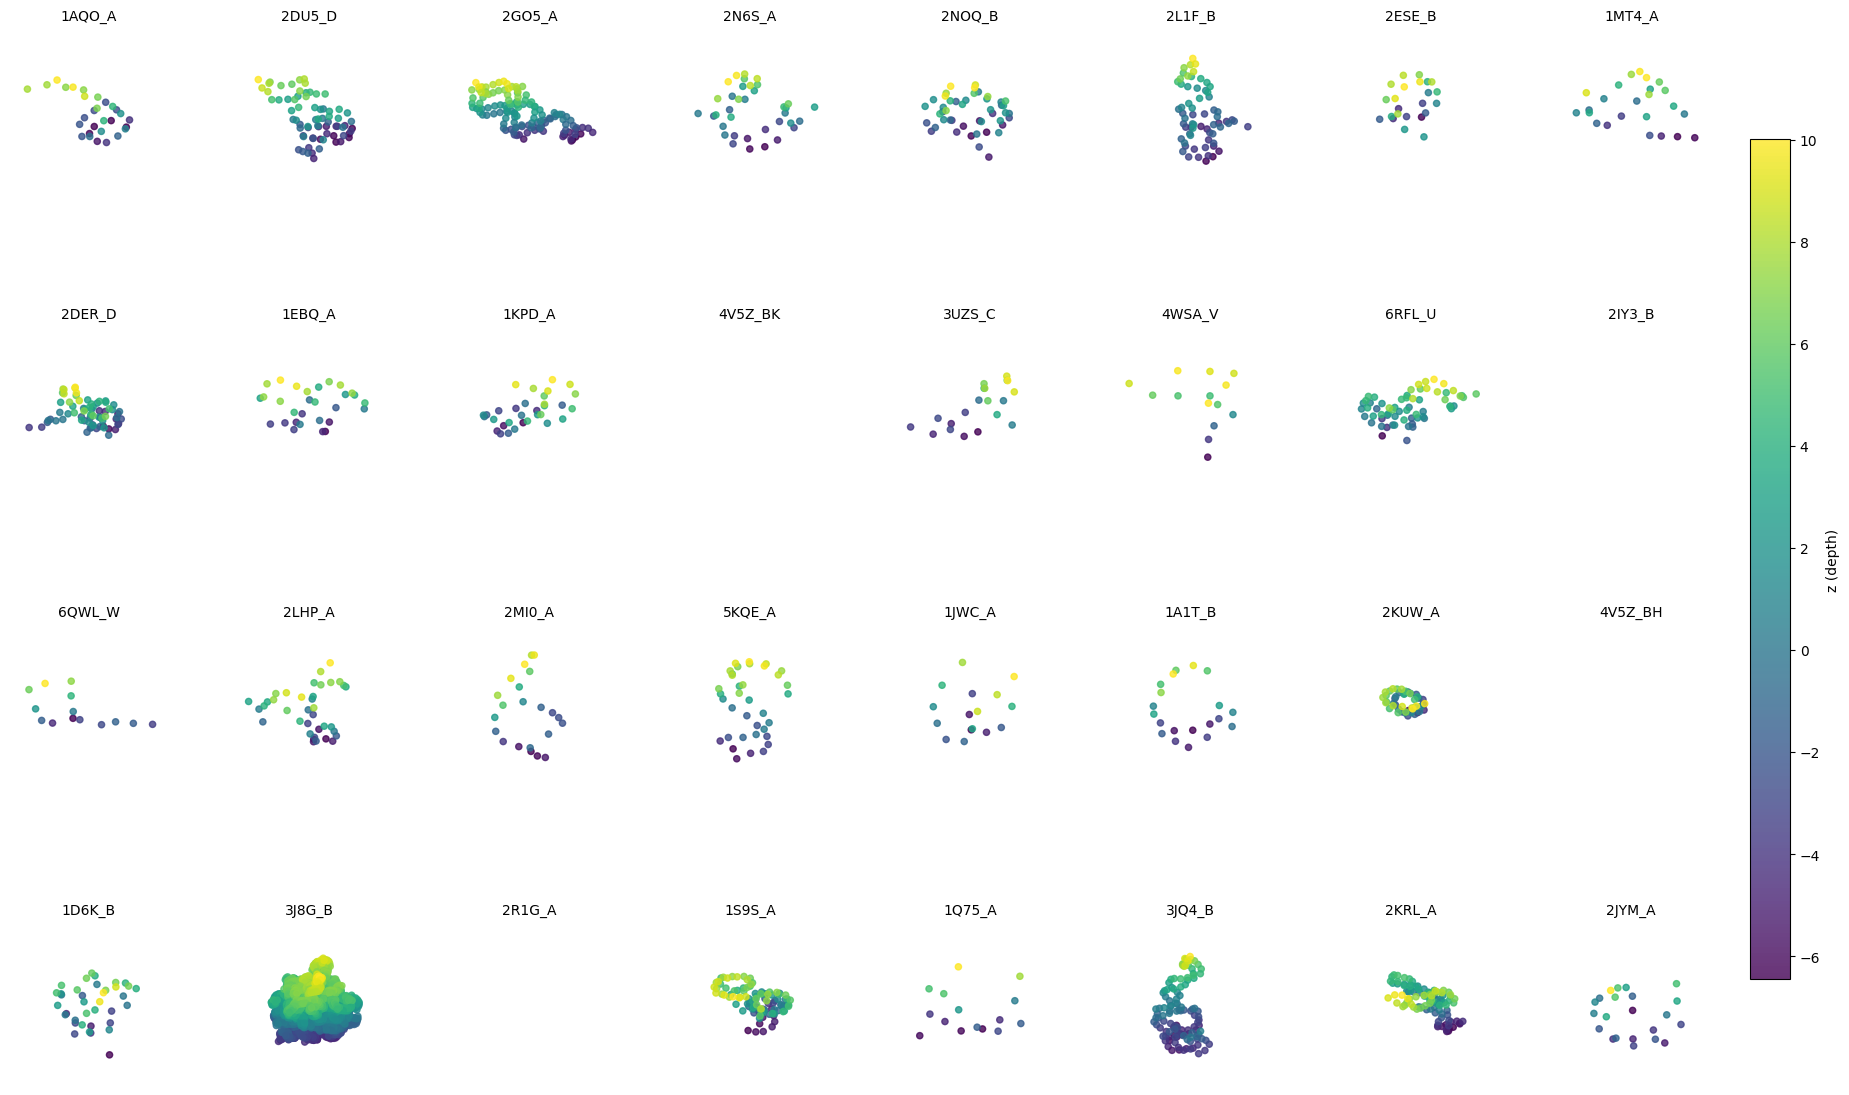

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Get unique target_ids from the dataset
all_target_ids = [data.target_id for data in train_graphs]
unique_target_ids = list(set(all_target_ids))

# Randomly sample 32 unique target_ids
selected_target_ids = np.random.choice(unique_target_ids, size=32, replace=False)

# Create 4x8 grid of subplots
fig, axes = plt.subplots(4, 8, figsize=(20, 12), subplot_kw={'projection': '3d'})
axes = axes.flatten()

for i, target_id in enumerate(selected_target_ids):
    axes[i].axis('off')

    # Find the corresponding graph in the dataset
    graph = next((g for g in train_dataset if g.target_id == target_id), None)
    
    if graph is None or graph.y is None:
        continue

    coords = graph.y.numpy()
    valid_mask = graph.mask.numpy().astype(bool) if graph.mask is not None else np.ones(len(coords), dtype=bool)

    x = coords[valid_mask, 0]
    y = coords[valid_mask, 1]
    z = coords[valid_mask, 2]

    sc = axes[i].scatter(x, y, z, c=z, cmap='viridis', alpha=0.8)
    axes[i].view_init(elev=30, azim=45)
    axes[i].set_title(f'{target_id}', fontsize=10, pad=10)

# Add shared colorbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
fig.colorbar(sc, cax=cbar_ax, label='z (depth)', orientation='vertical')

# Adjust layout
fig.subplots_adjust(left=0.05, right=0.9, top=0.95, bottom=0.05, wspace=0.4, hspace=0.6)

# Show plot
plt.show()


In [15]:
# Define loss function for 3D coordinate prediction
def rmsd_loss(pred, target, mask=None):
    """
    Root Mean Square Deviation (RMSD) loss function with optional masking for NaN values.
    Lower RMSD indicates better structural similarity.
    
    Args:
        pred: Predicted coordinates, shape (n_nucleotides, 3)
        target: Target coordinates, shape (n_nucleotides, 3)
        mask: Optional mask for valid values, shape (n_nucleotides,)
    """
    squared_diff = torch.sum((pred - target) ** 2, dim=1)
    
    if mask is not None:
        # Apply mask to consider only valid coordinates
        # Ensure we don't divide by zero by adding a small epsilon to the sum
        masked_squared_diff = squared_diff * mask
        mean_squared_diff = torch.sum(masked_squared_diff) / (torch.sum(mask) + 1e-10)
    else:
        mean_squared_diff = torch.mean(squared_diff)
    
    rmsd = torch.sqrt(mean_squared_diff)
    return rmsd

In [16]:
def calculate_distance_matrix(X,Y,epsilon=1e-4):
    return (torch.square(X[:,None]-Y[None,:])+epsilon).sum(-1).sqrt()


def dRMSD(pred_x,
          pred_y,
          gt_x,
          gt_y,
          epsilon=1e-4,Z=10,d_clamp=None):
    pred_dm=calculate_distance_matrix(pred_x,pred_y)
    gt_dm=calculate_distance_matrix(gt_x,gt_y)



    mask=~torch.isnan(gt_dm)
    mask[torch.eye(mask.shape[0]).bool()]=False

    if d_clamp is not None:
        rmsd=(torch.square(pred_dm[mask]-gt_dm[mask])+epsilon).clip(0,d_clamp**2)
    else:
        rmsd=torch.square(pred_dm[mask]-gt_dm[mask])+epsilon

    return rmsd.sqrt().mean()/Z

def local_dRMSD(pred_x,
          pred_y,
          gt_x,
          gt_y,
          epsilon=1e-4,Z=10,d_clamp=30):
    pred_dm=calculate_distance_matrix(pred_x,pred_y)
    gt_dm=calculate_distance_matrix(gt_x,gt_y)



    mask=(~torch.isnan(gt_dm))*(gt_dm<d_clamp)
    mask[torch.eye(mask.shape[0]).bool()]=False



    rmsd=torch.square(pred_dm[mask]-gt_dm[mask])+epsilon
    # rmsd=(torch.square(pred_dm[mask]-gt_dm[mask])+epsilon).sqrt()/Z
    #rmsd=torch.abs(pred_dm[mask]-gt_dm[mask])/Z
    return rmsd.sqrt().mean()/Z

def dRMAE(pred_x,
          pred_y,
          gt_x,
          gt_y,
          epsilon=1e-4,Z=10,d_clamp=None):
    pred_dm=calculate_distance_matrix(pred_x,pred_y)
    gt_dm=calculate_distance_matrix(gt_x,gt_y)



    mask=~torch.isnan(gt_dm)
    mask[torch.eye(mask.shape[0]).bool()]=False

    rmsd=torch.abs(pred_dm[mask]-gt_dm[mask])

    return rmsd.mean()/Z

import torch

def align_svd_mae(input, target, Z=10):
    """
    Aligns the input (Nx3) to target (Nx3) using SVD-based Procrustes alignment
    and computes RMSD loss.
    
    Args:
        input (torch.Tensor): Nx3 tensor representing the input points.
        target (torch.Tensor): Nx3 tensor representing the target points.
    
    Returns:
        aligned_input (torch.Tensor): Nx3 aligned input.
        rmsd_loss (torch.Tensor): RMSD loss.
    """
    assert input.shape == target.shape, "Input and target must have the same shape"

    #mask 
    mask=~torch.isnan(target.sum(-1))

    input=input[mask]
    target=target[mask]
    
    # Compute centroids
    centroid_input = input.mean(dim=0, keepdim=True)
    centroid_target = target.mean(dim=0, keepdim=True)

    # Center the points
    input_centered = input - centroid_input.detach()
    target_centered = target - centroid_target

    # Compute covariance matrix
    cov_matrix = input_centered.T @ target_centered

    # SVD to find optimal rotation
    U, S, Vt = torch.svd(cov_matrix)

    # Compute rotation matrix
    R = Vt @ U.T

    # Ensure a proper rotation (det(R) = 1, no reflection)
    if torch.det(R) < 0:
        Vt[-1, :] *= -1
        R = Vt @ U.T

    # Rotate input
    aligned_input = (input_centered @ R.T.detach()) + centroid_target.detach()

    # # Compute RMSD loss
    # rmsd_loss = torch.sqrt(((aligned_input - target) ** 2).mean())

    # rmsd_loss = torch.sqrt(((aligned_input - target) ** 2).mean())
    
    # return aligned_input, rmsd_loss
    return torch.abs(aligned_input-target).mean()/Z

In [17]:
def train(model, train_loader, optimizer, device):
    model.train()
    total_loss = 0
    loss_values = []
    # Create tqdm progress bar with loss display
    pbar = tqdm(train_loader, desc='Training')
    
    for data in pbar:
        data = data.to(device)
        optimizer.zero_grad()
        
        # Forward pass
        pred = model(data)
        
        # Calculate loss if labels exist
        if data.y is not None:
            # Use mask if available
            if hasattr(data, 'mask') and data.mask is not None:
                loss = dRMAE(pred,pred,data.y,data.y) + align_svd_mae(pred, data.y)
                # loss = rmsd_loss(pred, data.y, data.mask)
            else:
                loss = dRMAE(pred,pred,data.y,data.y) + align_svd_mae(pred, data.y)
                # loss = rmsd_loss(pred, data.y)
                
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            loss_values.append(loss.item())
            
            # Update progress bar with current loss
            pbar.set_postfix({'loss': f'{loss.item():.4f}', 'smooth loss': np.mean(loss_values[-100:])})
    
    avg_loss = total_loss / len(train_loader)
    return avg_loss

def validate(model, val_loader, device):
    model.eval()
    total_loss = 0
    
    # Create tqdm progress bar with loss display
    pbar = tqdm(val_loader, desc='Validation')
    
    with torch.no_grad():
        for data in pbar:
            data = data.to(device)
            pred = model(data)
            
            if data.y is not None:
                # Use mask if available
                if hasattr(data, 'mask') and data.mask is not None:
                    loss = dRMAE(pred,pred,data.y,data.y) + align_svd_mae(pred, data.y)
                    # loss = rmsd_loss(pred, data.y, data.mask)
                else:
                    loss = dRMAE(pred,pred,data.y,data.y) + align_svd_mae(pred, data.y)
                    # loss = rmsd_loss(pred, data.y)
                total_loss += loss.item()
                
                # Update progress bar with current loss
                pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    avg_loss = total_loss / len(val_loader)
    return avg_loss

# Function to make predictions on test data
def predict(model, test_loader, device):
    model.eval()
    predictions = {}
    
    with torch.no_grad():
        for data in test_loader:
            data = data.to(device)
            pred = model(data)
            
            # Store predictions
            target_id = data.target_id
            
            # If we have ground truth and mask, report metrics
            if hasattr(data, 'y') and data.y is not None:
                if hasattr(data, 'mask') and data.mask is not None:
                    loss = rmsd_loss(pred, data.y, data.mask).item()
                else:
                    loss = rmsd_loss(pred, data.y).item()
                print(f"Prediction for {target_id}, RMSD: {loss:.4f}")
            
            predictions[target_id] = pred.cpu().numpy()
    
    return predictions

In [18]:
# Setup for training
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
device = torch.device(device)
print(f"Using device: {device}")

Using device: cuda


In [19]:
# Create data loaders
train_loader = DataLoader(train_graphs, batch_size=8, shuffle=True, num_workers=4)
val_loader = DataLoader(val_graphs, batch_size=8, shuffle=False, num_workers=4)

/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [20]:
class EGNNLayer(MessagePassing):
    def __init__(self, hidden_dim):
        super().__init__(aggr='add')
        self.edge_mlp = nn.Sequential(
            nn.Linear(2 * hidden_dim + 1, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )
        self.node_mlp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU()
        )
        self.coord_mlp = nn.Sequential(
            nn.Linear(hidden_dim, 1),
            nn.Tanh()
        )

    def forward(self, x, edge_index, coords):
        edge_index, _ = remove_self_loops(edge_index)
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))
        return self.propagate(edge_index, x=x, coords=coords)

    def message(self, x_i, x_j, coords_i, coords_j):
        rel_coords = coords_i - coords_j
        dist = torch.sum(rel_coords ** 2, dim=-1, keepdim=True)
        edge_input = torch.cat([x_i, x_j, dist], dim=-1)
        m_ij = self.edge_mlp(edge_input)
        coord_update = self.coord_mlp(m_ij) * rel_coords
        return m_ij, coord_update

    def aggregate(self, inputs, index):
        msgs, coord_updates = inputs
        return (
            torch_scatter.scatter(msgs, index, dim=0),
            torch_scatter.scatter(coord_updates, index, dim=0)
        )

    def update(self, aggr_out, x, coords):
        x_update, coord_update = aggr_out
        x = x + self.node_mlp(x_update)
        coords = coords + coord_update
        return x, coords

In [21]:
class EGNNRNAStructurePredictor(nn.Module):
    def __init__(self, input_dim=4, hidden_dim=64, num_layers=4, max_seq_len=MAX_SEQ_LEN):
        super().__init__()
        self.embedding = nn.Linear(input_dim, hidden_dim)
        self.egnn_layers = nn.ModuleList([EGNNLayer(hidden_dim) for _ in range(num_layers)])
        self.coord_predictor = nn.Linear(hidden_dim, 3)
        self.position_encoder = nn.Embedding(max_seq_len, hidden_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        h = self.embedding(x)
        pos_indices = torch.arange(h.size(0), device=h.device).clamp(max=self.position_encoder.num_embeddings - 1)
        h = h + self.position_encoder(pos_indices)
        coords = torch.zeros(x.size(0), 3, device=x.device)
        for layer in self.egnn_layers:
            h, coords = layer(h, edge_index, coords)
        return coords

In [22]:
# Initialize model and data
model = EGNNRNAStructurePredictor(input_dim=4, hidden_dim=64, num_layers=3).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay = 1e-2)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=12)

num_epochs = 100
best_val_loss = float("inf")
early_stopping_patience = 50
early_stopping_counter = 0

In [23]:
train_losses = []
val_losses = []

print("Starting training...")
for epoch in range(1, num_epochs + 1):
    # --- Train ---
    train_loss = train(model, train_loader, optimizer, device)
    train_losses.append(train_loss)

    # --- Validate ---
    val_loss = validate(model, val_loader, device)
    val_losses.append(val_loss)

    # --- Adjust Learning Rate ---
    scheduler.step(val_loss)
    current_lr = optimizer.param_groups[0]['lr']

    # --- Check for Improvement ---
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stopping_counter = 0
        torch.save(model.state_dict(), "best_rna_structure_model.pt")
    else:
        early_stopping_counter += 1

    # --- Display formatted output ---
    print(f"Epoch {epoch:4d}/{num_epochs}, "
          f"Train Loss: {train_loss:.4f}, "
          f"Val Loss: {val_loss:.4f}, "
          f"LR: {current_lr:.6f}")

    # --- Early Stopping ---
    if early_stopping_counter >= early_stopping_patience:
        print(f"Early stopping triggered at epoch {epoch}")
        break

print("Training completed.")


Starting training...


Validation: 100%|██████████| 76/76 [00:03<00:00, 23.11it/s, loss=21.8392]


Epoch    1/100, Train Loss: 18.8546, Val Loss: 13.3715, LR: 0.001000


Validation: 100%|██████████| 76/76 [00:03<00:00, 25.03it/s, loss=21.8392]


Epoch    2/100, Train Loss: 16.9843, Val Loss: 13.3715, LR: 0.001000


Validation: 100%|██████████| 76/76 [00:03<00:00, 25.13it/s, loss=21.8392]


Epoch    3/100, Train Loss: 17.6279, Val Loss: 13.3715, LR: 0.001000


Validation: 100%|██████████| 76/76 [00:02<00:00, 25.51it/s, loss=21.8392]


Epoch    4/100, Train Loss: 18.0651, Val Loss: 13.3715, LR: 0.001000


Validation: 100%|██████████| 76/76 [00:02<00:00, 25.42it/s, loss=21.8392]


Epoch    5/100, Train Loss: 18.7330, Val Loss: 13.3715, LR: 0.001000


Validation: 100%|██████████| 76/76 [00:03<00:00, 25.12it/s, loss=21.8392]


Epoch    6/100, Train Loss: 17.9903, Val Loss: 13.3715, LR: 0.001000


Validation: 100%|██████████| 76/76 [00:03<00:00, 25.11it/s, loss=21.8392]


Epoch    7/100, Train Loss: 18.4100, Val Loss: 13.3715, LR: 0.001000


Validation: 100%|██████████| 76/76 [00:02<00:00, 25.95it/s, loss=21.8392]


Epoch    8/100, Train Loss: 18.6033, Val Loss: 13.3715, LR: 0.001000


Validation: 100%|██████████| 76/76 [00:03<00:00, 24.60it/s, loss=21.8392]


Epoch    9/100, Train Loss: 19.6452, Val Loss: 13.3715, LR: 0.001000


Validation: 100%|██████████| 76/76 [00:03<00:00, 24.99it/s, loss=21.8392]


Epoch   10/100, Train Loss: 18.4745, Val Loss: 13.3715, LR: 0.001000


Validation: 100%|██████████| 76/76 [00:02<00:00, 26.17it/s, loss=21.8392]


Epoch   11/100, Train Loss: 18.6119, Val Loss: 13.3715, LR: 0.001000


Validation: 100%|██████████| 76/76 [00:03<00:00, 24.95it/s, loss=21.8392]


Epoch   12/100, Train Loss: 17.8664, Val Loss: 13.3715, LR: 0.001000


Validation: 100%|██████████| 76/76 [00:03<00:00, 25.20it/s, loss=21.8392]


Epoch   13/100, Train Loss: 18.8839, Val Loss: 13.3715, LR: 0.001000


Validation: 100%|██████████| 76/76 [00:03<00:00, 23.95it/s, loss=21.8392]


Epoch   14/100, Train Loss: 18.2643, Val Loss: 13.3715, LR: 0.000500


Validation: 100%|██████████| 76/76 [00:02<00:00, 25.43it/s, loss=21.8392]


Epoch   15/100, Train Loss: 17.2914, Val Loss: 13.3715, LR: 0.000500


Validation: 100%|██████████| 76/76 [00:02<00:00, 25.54it/s, loss=21.8392]


Epoch   16/100, Train Loss: 18.1044, Val Loss: 13.3715, LR: 0.000500


Validation: 100%|██████████| 76/76 [00:03<00:00, 25.19it/s, loss=21.8392]


Epoch   17/100, Train Loss: 18.4577, Val Loss: 13.3715, LR: 0.000500


Validation: 100%|██████████| 76/76 [00:03<00:00, 25.27it/s, loss=21.8392]


Epoch   18/100, Train Loss: 19.4844, Val Loss: 13.3715, LR: 0.000500


Validation: 100%|██████████| 76/76 [00:03<00:00, 22.84it/s, loss=21.8392]


Epoch   19/100, Train Loss: 18.3490, Val Loss: 13.3715, LR: 0.000500


Validation: 100%|██████████| 76/76 [00:03<00:00, 25.14it/s, loss=21.8392]


Epoch   20/100, Train Loss: 18.5592, Val Loss: 13.3715, LR: 0.000500


Validation: 100%|██████████| 76/76 [00:02<00:00, 25.73it/s, loss=21.8392]


Epoch   21/100, Train Loss: 18.0289, Val Loss: 13.3715, LR: 0.000500


Validation: 100%|██████████| 76/76 [00:02<00:00, 25.37it/s, loss=21.8392]


Epoch   22/100, Train Loss: 18.2384, Val Loss: 13.3715, LR: 0.000500


Validation: 100%|██████████| 76/76 [00:03<00:00, 24.93it/s, loss=21.8392]


Epoch   23/100, Train Loss: 18.7392, Val Loss: 13.3715, LR: 0.000500


Validation: 100%|██████████| 76/76 [00:03<00:00, 23.78it/s, loss=21.8392]


Epoch   24/100, Train Loss: 17.7657, Val Loss: 13.3715, LR: 0.000500


Validation: 100%|██████████| 76/76 [00:03<00:00, 25.07it/s, loss=21.8392]


Epoch   25/100, Train Loss: 19.3278, Val Loss: 13.3715, LR: 0.000500


Validation: 100%|██████████| 76/76 [00:02<00:00, 25.68it/s, loss=21.8392]


Epoch   26/100, Train Loss: 18.3091, Val Loss: 13.3715, LR: 0.000500


Validation: 100%|██████████| 76/76 [00:02<00:00, 25.86it/s, loss=21.8392]


Epoch   27/100, Train Loss: 17.7659, Val Loss: 13.3715, LR: 0.000250


Validation: 100%|██████████| 76/76 [00:03<00:00, 25.17it/s, loss=21.8392]


Epoch   28/100, Train Loss: 19.1401, Val Loss: 13.3715, LR: 0.000250


Validation: 100%|██████████| 76/76 [00:03<00:00, 25.30it/s, loss=21.8392]


Epoch   29/100, Train Loss: 17.8457, Val Loss: 13.3715, LR: 0.000250


Validation: 100%|██████████| 76/76 [00:02<00:00, 25.73it/s, loss=21.8392]


Epoch   30/100, Train Loss: 17.9173, Val Loss: 13.3715, LR: 0.000250


Validation: 100%|██████████| 76/76 [00:02<00:00, 25.91it/s, loss=21.8392]


Epoch   31/100, Train Loss: 18.1613, Val Loss: 13.3715, LR: 0.000250


Validation: 100%|██████████| 76/76 [00:02<00:00, 25.60it/s, loss=21.8392]


Epoch   32/100, Train Loss: 18.0710, Val Loss: 13.3715, LR: 0.000250


Validation: 100%|██████████| 76/76 [00:02<00:00, 25.45it/s, loss=21.8392]


Epoch   33/100, Train Loss: 17.7797, Val Loss: 13.3715, LR: 0.000250


Validation: 100%|██████████| 76/76 [00:02<00:00, 25.85it/s, loss=21.8392]


Epoch   34/100, Train Loss: 18.5539, Val Loss: 13.3715, LR: 0.000250


Validation: 100%|██████████| 76/76 [00:03<00:00, 21.50it/s, loss=21.8392]


Epoch   35/100, Train Loss: 18.8897, Val Loss: 13.3715, LR: 0.000250


Validation: 100%|██████████| 76/76 [00:03<00:00, 24.98it/s, loss=21.8392]


Epoch   36/100, Train Loss: 18.6024, Val Loss: 13.3715, LR: 0.000250


Validation: 100%|██████████| 76/76 [00:02<00:00, 25.99it/s, loss=21.8392]


Epoch   37/100, Train Loss: 16.6262, Val Loss: 13.3715, LR: 0.000250


Validation: 100%|██████████| 76/76 [00:03<00:00, 24.71it/s, loss=21.8392]


Epoch   38/100, Train Loss: 18.8067, Val Loss: 13.3715, LR: 0.000250


Validation: 100%|██████████| 76/76 [00:02<00:00, 25.56it/s, loss=21.8392]


Epoch   39/100, Train Loss: 17.4349, Val Loss: 13.3715, LR: 0.000250


Validation: 100%|██████████| 76/76 [00:03<00:00, 22.03it/s, loss=21.8392]


Epoch   40/100, Train Loss: 17.7839, Val Loss: 13.3715, LR: 0.000125


Validation: 100%|██████████| 76/76 [00:03<00:00, 25.17it/s, loss=21.8392]


Epoch   41/100, Train Loss: 18.7251, Val Loss: 13.3715, LR: 0.000125


Validation: 100%|██████████| 76/76 [00:02<00:00, 25.36it/s, loss=21.8392]


Epoch   42/100, Train Loss: 18.5760, Val Loss: 13.3715, LR: 0.000125


Validation: 100%|██████████| 76/76 [00:03<00:00, 25.08it/s, loss=21.8392]


Epoch   43/100, Train Loss: 17.5885, Val Loss: 13.3715, LR: 0.000125


Validation: 100%|██████████| 76/76 [00:03<00:00, 25.19it/s, loss=21.8392]


Epoch   44/100, Train Loss: 18.1663, Val Loss: 13.3715, LR: 0.000125


Validation: 100%|██████████| 76/76 [00:03<00:00, 24.59it/s, loss=21.8392]


Epoch   45/100, Train Loss: 18.6472, Val Loss: 13.3715, LR: 0.000125


Validation: 100%|██████████| 76/76 [00:02<00:00, 25.73it/s, loss=21.8392]


Epoch   46/100, Train Loss: 17.4600, Val Loss: 13.3715, LR: 0.000125


Validation: 100%|██████████| 76/76 [00:03<00:00, 25.17it/s, loss=21.8392]


Epoch   47/100, Train Loss: 16.9043, Val Loss: 13.3715, LR: 0.000125


Validation: 100%|██████████| 76/76 [00:03<00:00, 25.17it/s, loss=21.8392]


Epoch   48/100, Train Loss: 17.7981, Val Loss: 13.3715, LR: 0.000125


Validation: 100%|██████████| 76/76 [00:02<00:00, 26.08it/s, loss=21.8392]


Epoch   49/100, Train Loss: 18.3055, Val Loss: 13.3715, LR: 0.000125


Validation: 100%|██████████| 76/76 [00:02<00:00, 25.53it/s, loss=21.8392]


Epoch   50/100, Train Loss: 18.7912, Val Loss: 13.3715, LR: 0.000125


Validation: 100%|██████████| 76/76 [00:03<00:00, 25.27it/s, loss=21.8392]

Epoch   51/100, Train Loss: 17.9667, Val Loss: 13.3715, LR: 0.000125
Early stopping triggered at epoch 51
Training completed.


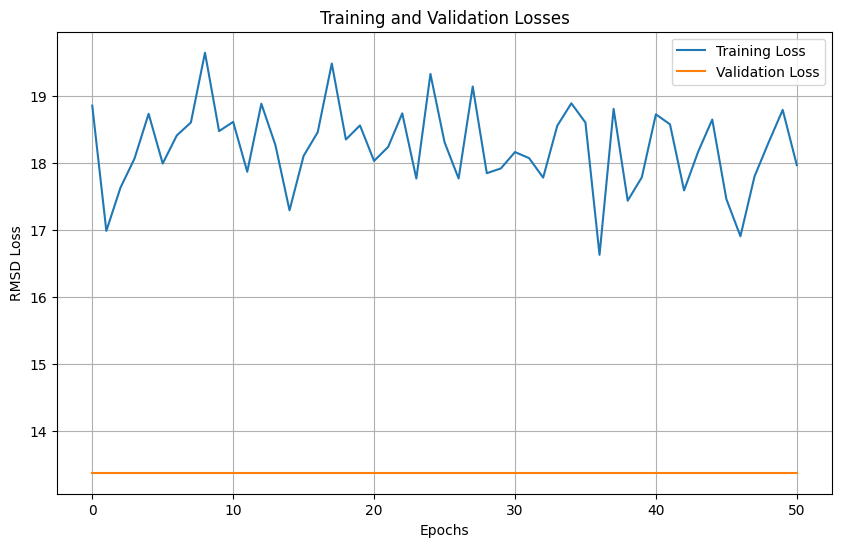

In [24]:
# Plot training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('RMSD Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.grid(True)
plt.show()

In [25]:
# Generate multiple conformations for each RNA sequence
def generate_multiple_conformations(model, data, num_conformations=5):
    """
    Generate multiple structural conformations for an RNA sequence.
    
    Args:
        model: The trained GNN model
        data: Graph data object containing the RNA sequence
        num_conformations: Number of conformations to generate (default: 5)
        
    Returns:
        List of numpy arrays, each array has shape (n_nucleotides, 3) for x,y,z coordinates
    """
    model.eval()
    conformations = []
    
    # Set random seed for reproducibility
    torch.manual_seed(42)
    
    with torch.no_grad():
        # Generate first conformation (deterministic)
        base_pred = model(data)
        base_np = base_pred.cpu().numpy()
        
        # Check if base prediction contains NaN values
        if np.isnan(base_np).any():
            print("Warning: Base prediction contains NaN values. Replacing with zeros.")
            base_np = np.nan_to_num(base_np, nan=0.0)
        
        # Save the base prediction
        conformations.append(base_np)
        
        # Generate additional conformations with controlled variations
        for i in range(1, num_conformations):
            # Use different seeds for different conformations
            torch.manual_seed(42 + i * 100)  # Larger seed increment for more diversity
            
            # Create a copy of the base prediction with a small, controlled variation
            variation = base_np.copy()
            
            # Add random noise with small magnitude (1-5% of the coordinate values)
            # Calculate standard deviation of base coordinates to scale noise appropriately
            if not np.all(base_np == 0):  # Check if base_np is not all zeros
                coord_std = max(np.std(base_np), 0.5)  # Use at least 0.5 to avoid too small noise
                noise_scale = coord_std * 0.05 * (i + 1)  # Increasing noise for each conformation
            else:
                # If base prediction is all zeros (which shouldn't happen normally)
                noise_scale = 0.5 * (i + 1)
            
            # Generate noise and ensure it's not NaN
            noise = np.random.normal(0, noise_scale, size=variation.shape)
            
            # Apply noise to create a new conformation
            variation += noise
            
            # Ensure no NaN values
            variation = np.nan_to_num(variation, nan=0.0)
            
            conformations.append(variation)
    
    # Double-check that all conformations are valid and contain no NaNs
    for i, conf in enumerate(conformations):
        if np.isnan(conf).any():
            print(f"Warning: Conformation {i+1} contains NaN values after processing. Replacing with zeros.")
            conformations[i] = np.nan_to_num(conf, nan=0.0)
    
    return conformations

# Function to make multiple predictions for test data
def predict_multiple_conformations(model, test_loader, device, num_conformations=5):
    predictions = {}
    
    for data in test_loader:
        data = data.to(device)
        conformations = generate_multiple_conformations(model, data, num_conformations)
        
        # Store predictions - ensure target_id is a hashable type (string)
        # The target_id could be stored as a list or other non-hashable type
        if hasattr(data, 'target_id'):
            # Convert to string if it's not already
            if isinstance(data.target_id, list) and len(data.target_id) > 0:
                target_id = str(data.target_id[0])  # Take the first element if it's a list
            else:
                target_id = str(data.target_id)  # Convert to string to ensure hashability
        else:
            # Generate a unique ID if none exists
            target_id = f"unknown_target_{len(predictions)}"
            
        print(f"Processing target: {target_id}")
        predictions[target_id] = conformations
        
        # If we have ground truth, report metrics for the first conformation
        if hasattr(data, 'y') and data.y is not None and len(conformations) > 0:
            first_conf = torch.tensor(conformations[0], device=device)
            
            if hasattr(data, 'mask') and data.mask is not None:
                loss = rmsd_loss(first_conf, data.y, data.mask).item()
            else:
                loss = rmsd_loss(first_conf, data.y).item()
                
            print(f"Prediction for {target_id}, RMSD of first conformation: {loss:.4f}")
    
    return predictions

# Example of how to use the prediction function on test data
def process_test_data(test_sequences_path):
    # Load test sequences
    test_sequences = pd.read_csv(test_sequences_path)
    
    # Create test dataset (without labels)
    test_dataset = create_dataset(test_sequences)
    
    # Create test loader
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
    
    # Make predictions
    predictions = predict_multiple_conformations(model, test_loader, device)
    
    # Format predictions for submission
    formatted_predictions = []
    
    for target_id, conformations in predictions.items():
        for i, conformation in enumerate(conformations):
            for j, coords in enumerate(conformation):
                resid = j + 1  # 1-based indexing
                row = {
                    'ID': f"{target_id}_{resid}",
                    f'x_{i+1}': coords[0],
                    f'y_{i+1}': coords[1],
                    f'z_{i+1}': coords[2]
                }
                formatted_predictions.append(row)
    
    # Create submission dataframe
    submission_df = pd.DataFrame(formatted_predictions)
    return submission_df

In [26]:
test_predictions = process_test_data("/kaggle/input/stanford-rna-3d-folding/test_sequences.csv")
sub = pd.read_csv("/kaggle/input/stanford-rna-3d-folding/sample_submission.csv")
DF_ROWS = []

for i, row in sub.iterrows():
    snap = test_predictions[test_predictions['ID'] == row['ID']]
    x1, y1, z1, x2, y2, z2, x3, y3, z3, x4, y4, z4, x5, y5, z5 = snap['x_1'], snap['y_1'], snap['z_1'], snap['x_2'], snap['y_2'], snap['z_2'], snap['x_3'], snap['y_3'], snap['z_3'], snap['x_4'], snap['y_4'], snap['z_4'], snap['x_5'], snap['y_5'], snap['z_5']
    x1, y1, z1, x2, y2, z2, x3, y3, z3, x4, y4, z4, x5, y5, z5 = x1.values[0], y1.values[0], z1.values[0], x2.values[1], y2.values[1], z2.values[1], x3.values[2], y3.values[2], z3.values[2], x4.values[3], y4.values[3], z4.values[3], x5.values[4], y5.values[4], z5.values[4]
    _row = [x1, y1, z1, x2, y2, z2, x3, y3, z3, x4, y4, z4, x5, y5, z5]
    DF_ROWS.append(_row)
sub[['x_1', 'y_1', 'z_1', 'x_2', 'y_2', 'z_2', 'x_3', 'y_3', 'z_3', 'x_4', 'y_4', 'z_4', 'x_5', 'y_5', 'z_5']] = DF_ROWS
sub.head()
sub.to_csv("submission.csv", index=False)

100%|██████████| 12/12 [00:00<00:00, 202.95it/s]
/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Dataset creation: 0 sequences skipped due to non-standard nucleotides
Dataset creation: 0 sequences have >50% NaN coordinates
Processing target: R1107
Processing target: R1108
Processing target: R1116
Processing target: R1117v2
Processing target: R1126
Processing target: R1128
Processing target: R1136
Processing target: R1138
Processing target: R1149
Processing target: R1156
Processing target: R1189
Processing target: R1190


## Acknowledgement

This code is copy and modify from this notebook:
https://www.kaggle.com/code/salmanahmedtamu/a-simple-gnn-implementation